<a href="https://colab.research.google.com/github/ndimitrakas/MLNBAOutcomes/blob/main/GraduateCapstoneProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
!pip install comet_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.8/509.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.1/510.1 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.5.1
    Uninstalling websocket-client-1.5.1:
      Successfully uninstalled websocket-client-1.5.1


In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from comet_ml import Experiment
import pandas as pd
import numpy as np
import datetime
import io
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from tqdm.notebook import tqdm
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from pandas.core.window import rolling
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn import svm

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Collection
   * data has been collected from kaggle https://www.kaggle.com/datasets/salikhussaini49/nba-dataset?resource=download&select=NBA_GAMES_1950_2022_.csv
   * Has all the relevant stats that will be needed for the project

In [ ]:
path = "/content/drive/MyDrive/NBA_GAMES_1950_2022_.csv"
raw_df = pd.read_csv(path)
raw_df = raw_df.set_index('Team_ID')
raw_df.dtypes

Game_ID                int64
GAME_DATE             object
MATCHUP               object
WL                    object
W                    float64
L                    float64
W_PCT                float64
MIN                    int64
FGM                  float64
FGA                  float64
FG_PCT               float64
FG3M                 float64
FG3A                 float64
FG3_PCT              float64
FTM                  float64
FTA                  float64
FT_PCT               float64
OREB                 float64
DREB                 float64
REB                    int64
AST                  float64
STL                  float64
BLK                  float64
TOV                  float64
PF                   float64
PTS                    int64
SEASON_ID            float64
TEAM_NAME             object
TEAM_ABBREVIATION     object
dtype: object

# Data Cleaning
* We must prepare the data by cleaning and preprocessing it to ensure that it is suitable for analysis
 * Check for missing values, standardize/normalize the data, etc
 * How will I deal with null/nan values?
* I will be cutting this dataframe from start date of 1950 to start date around October of 2003.
 * Reason for this being that I wanted to keep the model trained on the more recent data from the players that are actively playing in the league
 * The oldest most relevant player in today's NBA is **Lebron James** and he debuted in late October of 2003
* Dropping the column called 'SEASON_ID' because it only contains NANs

In [ ]:
# TODO: Change the game date from string types to datetime types
raw_df['GAME_DATE'] = pd.to_datetime(raw_df['GAME_DATE'])
raw_df = raw_df.drop('SEASON_ID', axis=1)
raw_df

,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_NAME,TEAM_ABBREVIATION
Team_ID,,,,,,,,,,,,,,,,,,,,,
1610612737,28000934,1981-03-29,ATL vs. MIL,L,NaN,NaN,NaN,265,41.0,NaN,...,NaN,0,NaN,NaN,NaN,NaN,35.0,128,Atlanta Hawks,ATL
1610612737,28000921,1981-03-27,ATL @ CHI,L,NaN,NaN,NaN,240,40.0,NaN,...,NaN,0,NaN,NaN,NaN,NaN,24.0,83,Atlanta Hawks,ATL
1610612737,28000919,1981-03-26,ATL vs. IND,L,NaN,NaN,NaN,240,43.0,NaN,...,NaN,0,NaN,NaN,NaN,NaN,26.0,107,Atlanta Hawks,ATL
1610612737,28000908,1981-03-24,ATL vs. DET,W,NaN,NaN,NaN,240,41.0,NaN,...,NaN,0,NaN,NaN,NaN,NaN,23.0,96,Atlanta Hawks,ATL
1610612737,28000895,1981-03-22,ATL @ WAS,L,NaN,NaN,NaN,240,40.0,NaN,...,NaN,0,NaN,NaN,NaN,NaN,27.0,101,Atlanta Hawks,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610612765,27800049,1978-10-21,DET @ WAS,L,NaN,NaN,NaN,240,42.0,NaN,...,NaN,0,NaN,NaN,NaN,NaN,23.0,99,Detroit Pistons,DET
1610612765,27800038,1978-10-20,DET vs. PHL,L,NaN,NaN,NaN,240,45.0,NaN,...,NaN,0,NaN,NaN,NaN,NaN,34.0,117,Detroit Pistons,DET
1610612765,27800023,1978-10-17,DET @ NOJ,L,NaN,NaN,NaN,240,45.0,NaN,...,NaN,0,NaN,NaN,NaN,NaN,26.0,109,Detroit Pistons,DET


In [ ]:
# TODO: Filter the dataframe down from lebrons first game to present date
season_2003_2004_start_date = datetime.datetime(2003, 10, 28)
season_2004_2005_start_date = datetime.datetime(2004, 10, 31)
season_2005_2006_start_date = datetime.datetime(2005, 10, 31)
season_2006_2007_start_date = datetime.datetime(2006, 10, 30)
season_2007_2008_start_date = datetime.datetime(2007, 10, 29)
season_2008_2009_start_date = datetime.datetime(2008, 10, 27)
season_2009_2010_start_date = datetime.datetime(2009, 10, 26)
season_2010_2011_start_date = datetime.datetime(2010, 10, 25)
season_2011_2012_start_date = datetime.datetime(2011, 12, 24)
season_2012_2013_start_date = datetime.datetime(2012, 10, 29)
season_2013_2014_start_date = datetime.datetime(2013, 10, 28)
season_2014_2015_start_date = datetime.datetime(2014, 10, 27)
season_2015_2016_start_date = datetime.datetime(2015, 10, 26)
season_2016_2017_start_date = datetime.datetime(2016, 10, 24)
season_2017_2018_start_date = datetime.datetime(2017, 10, 16)
season_2018_2019_start_date = datetime.datetime(2018, 10, 15)
season_2019_2020_start_date = datetime.datetime(2019, 10, 21)
season_2020_2021_start_date = datetime.datetime(2020, 12, 21)
season_2021_2022_start_date = datetime.datetime(2021, 10, 18)
season_2022_2023_start_date = datetime.datetime(2022, 10, 17)
present = datetime.datetime(2023, 4, 20)
season_start_dates_list = [season_2003_2004_start_date, season_2004_2005_start_date, season_2005_2006_start_date, season_2006_2007_start_date, season_2007_2008_start_date,
                           season_2008_2009_start_date, season_2009_2010_start_date, season_2010_2011_start_date, season_2011_2012_start_date, season_2012_2013_start_date,
                           season_2013_2014_start_date, season_2014_2015_start_date, season_2015_2016_start_date, season_2016_2017_start_date, season_2017_2018_start_date,
                           season_2018_2019_start_date, season_2019_2020_start_date, season_2020_2021_start_date, season_2021_2022_start_date, season_2022_2023_start_date, present]
lebron_era_df = raw_df[raw_df['GAME_DATE'] >= season_2003_2004_start_date]
lebron_era_df

,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_NAME,TEAM_ABBREVIATION
Team_ID,,,,,,,,,,,,,,,,,,,,,
1610612737,20301176,2004-04-14,ATL @ BOS,L,28.0,54.0,0.341,240,48.0,91.0,...,26.0,40,32.0,8.0,2.0,18.0,26.0,132,Atlanta Hawks,ATL
1610612737,20301164,2004-04-12,ATL vs. NJN,W,28.0,53.0,0.346,240,47.0,80.0,...,24.0,35,30.0,10.0,5.0,10.0,20.0,129,Atlanta Hawks,ATL
1610612737,20301150,2004-04-10,ATL vs. BOS,W,27.0,53.0,0.338,240,41.0,83.0,...,27.0,42,23.0,8.0,3.0,15.0,24.0,110,Atlanta Hawks,ATL
1610612737,20301142,2004-04-09,ATL @ CHI,W,26.0,53.0,0.329,240,44.0,89.0,...,29.0,42,35.0,13.0,6.0,12.0,21.0,116,Atlanta Hawks,ATL
1610612737,20301117,2004-04-06,ATL vs. PHI,L,25.0,53.0,0.321,265,36.0,86.0,...,31.0,46,21.0,11.0,4.0,15.0,23.0,100,Atlanta Hawks,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610612766,22200071,2022-10-28,CHA @ ORL,L,2.0,3.0,0.400,240,33.0,86.0,...,37.0,47,21.0,3.0,4.0,14.0,18.0,93,Charlotte Hornets,CHA
1610612766,22200058,2022-10-26,CHA @ NYK,L,2.0,2.0,0.500,265,49.0,99.0,...,33.0,42,31.0,9.0,5.0,15.0,24.0,131,Charlotte Hornets,CHA
1610612766,22200038,2022-10-23,CHA @ ATL,W,2.0,1.0,0.667,240,47.0,90.0,...,38.0,52,28.0,7.0,6.0,13.0,24.0,126,Charlotte Hornets,CHA


## Data Issues
* Our first data cleaning issue is that there was a game that was cancelled between the **Celtics** and the **Pacers** on **April 16, 2013** and there are nan values there for statistics and win/loss. We will drop these rows.
* We also have nans in the 'W' and 'L' and 'W_PCT' columns
 * TBD what will be done with those after investigation
 * For some reason, wins and loses in the database not saved into dataframe. May have to go in manually and fill this out correctly.

In [ ]:
# TODO: Take care of the cancelled nba game with nan values
lebron_era_df[lebron_era_df['WL'].isna() == True]
lebron_era_df = lebron_era_df.dropna(subset=['WL'])

In [ ]:
# TODO: Change the WL column name to OUTCOME and change the strings to 1/0
#       (1 for win, 0 for loss)
lebron_era_df = lebron_era_df.rename(columns={'WL': 'OUTCOME'})
lebron_era_df['OUTCOME'] = lebron_era_df['OUTCOME'].replace({'W': 1, 'L': 0})
lebron_era_df['OUTCOME'].unique()
lebron_era_df

,Game_ID,GAME_DATE,MATCHUP,OUTCOME,W,L,W_PCT,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_NAME,TEAM_ABBREVIATION
Team_ID,,,,,,,,,,,,,,,,,,,,,
1610612737,20301176,2004-04-14,ATL @ BOS,0,28.0,54.0,0.341,240,48.0,91.0,...,26.0,40,32.0,8.0,2.0,18.0,26.0,132,Atlanta Hawks,ATL
1610612737,20301164,2004-04-12,ATL vs. NJN,1,28.0,53.0,0.346,240,47.0,80.0,...,24.0,35,30.0,10.0,5.0,10.0,20.0,129,Atlanta Hawks,ATL
1610612737,20301150,2004-04-10,ATL vs. BOS,1,27.0,53.0,0.338,240,41.0,83.0,...,27.0,42,23.0,8.0,3.0,15.0,24.0,110,Atlanta Hawks,ATL
1610612737,20301142,2004-04-09,ATL @ CHI,1,26.0,53.0,0.329,240,44.0,89.0,...,29.0,42,35.0,13.0,6.0,12.0,21.0,116,Atlanta Hawks,ATL
1610612737,20301117,2004-04-06,ATL vs. PHI,0,25.0,53.0,0.321,265,36.0,86.0,...,31.0,46,21.0,11.0,4.0,15.0,23.0,100,Atlanta Hawks,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610612766,22200071,2022-10-28,CHA @ ORL,0,2.0,3.0,0.400,240,33.0,86.0,...,37.0,47,21.0,3.0,4.0,14.0,18.0,93,Charlotte Hornets,CHA
1610612766,22200058,2022-10-26,CHA @ NYK,0,2.0,2.0,0.500,265,49.0,99.0,...,33.0,42,31.0,9.0,5.0,15.0,24.0,131,Charlotte Hornets,CHA
1610612766,22200038,2022-10-23,CHA @ ATL,1,2.0,1.0,0.667,240,47.0,90.0,...,38.0,52,28.0,7.0,6.0,13.0,24.0,126,Charlotte Hornets,CHA


In [ ]:
# Possibly drop this data, may have to go manually and fix this
#lebron_era_df[lebron_era_df['W'].isna() == True]

In [ ]:
clean_lebron_era_df = lebron_era_df[~lebron_era_df['W'].isna() == True]
clean_lebron_era_df

,Game_ID,GAME_DATE,MATCHUP,OUTCOME,W,L,W_PCT,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_NAME,TEAM_ABBREVIATION
Team_ID,,,,,,,,,,,,,,,,,,,,,
1610612737,20301176,2004-04-14,ATL @ BOS,0,28.0,54.0,0.341,240,48.0,91.0,...,26.0,40,32.0,8.0,2.0,18.0,26.0,132,Atlanta Hawks,ATL
1610612737,20301164,2004-04-12,ATL vs. NJN,1,28.0,53.0,0.346,240,47.0,80.0,...,24.0,35,30.0,10.0,5.0,10.0,20.0,129,Atlanta Hawks,ATL
1610612737,20301150,2004-04-10,ATL vs. BOS,1,27.0,53.0,0.338,240,41.0,83.0,...,27.0,42,23.0,8.0,3.0,15.0,24.0,110,Atlanta Hawks,ATL
1610612737,20301142,2004-04-09,ATL @ CHI,1,26.0,53.0,0.329,240,44.0,89.0,...,29.0,42,35.0,13.0,6.0,12.0,21.0,116,Atlanta Hawks,ATL
1610612737,20301117,2004-04-06,ATL vs. PHI,0,25.0,53.0,0.321,265,36.0,86.0,...,31.0,46,21.0,11.0,4.0,15.0,23.0,100,Atlanta Hawks,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610612766,22200071,2022-10-28,CHA @ ORL,0,2.0,3.0,0.400,240,33.0,86.0,...,37.0,47,21.0,3.0,4.0,14.0,18.0,93,Charlotte Hornets,CHA
1610612766,22200058,2022-10-26,CHA @ NYK,0,2.0,2.0,0.500,265,49.0,99.0,...,33.0,42,31.0,9.0,5.0,15.0,24.0,131,Charlotte Hornets,CHA
1610612766,22200038,2022-10-23,CHA @ ATL,1,2.0,1.0,0.667,240,47.0,90.0,...,38.0,52,28.0,7.0,6.0,13.0,24.0,126,Charlotte Hornets,CHA


# Pre-Processing: 10 Game Rolling Averages
* Need to make 10 game rolling averages for each team
* Make sure the data is sorted chronologically
* Make sure that the game being played is not included in the rolling average as that would be cheating the model
* Append the rolling averages to the end of the dataframe

In [ ]:
# 1. filter df by team and find all unique dates for team
# 2. sort chronologically
# 3. for loop where i grab 10 rows and average them
## columns are all the current columns just with rolling avg past 10 games
rolling_avg_df = clean_lebron_era_df
rolling_avg_df = rolling_avg_df.sort_values(by="GAME_DATE", ascending = True)
rolling_avg_df

,Game_ID,GAME_DATE,MATCHUP,OUTCOME,W,L,W_PCT,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_NAME,TEAM_ABBREVIATION
Team_ID,,,,,,,,,,,,,,,,,,,,,
1610612755,20300001,2003-10-28,PHI vs. MIA,1,1.0,0.0,1.000,240,33.0,75.0,...,27.0,39,25.0,12.0,3.0,8.0,19.0,89,Philadelphia 76ers,PHI
1610612748,20300001,2003-10-28,MIA @ PHI,0,0.0,1.0,0.000,240,29.0,71.0,...,32.0,44,16.0,3.0,2.0,19.0,22.0,74,Miami Heat,MIA
1610612747,20300003,2003-10-28,LAL vs. DAL,1,1.0,0.0,1.000,240,45.0,89.0,...,39.0,46,32.0,7.0,6.0,10.0,28.0,109,Los Angeles Lakers,LAL
1610612756,20300002,2003-10-28,PHX @ SAS,0,0.0,1.0,0.000,240,30.0,83.0,...,26.0,43,14.0,7.0,5.0,18.0,32.0,82,Phoenix Suns,PHX
1610612742,20300003,2003-10-28,DAL @ LAL,0,0.0,1.0,0.000,240,32.0,85.0,...,35.0,46,17.0,4.0,1.0,11.0,21.0,93,Dallas Mavericks,DAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610612756,22200885,2023-02-16,PHX vs. LAC,0,32.0,28.0,0.533,240,42.0,89.0,...,31.0,38,30.0,10.0,2.0,12.0,24.0,107,Phoenix Suns,PHX
1610612749,22200883,2023-02-16,MIL @ CHI,1,41.0,17.0,0.707,240,40.0,88.0,...,43.0,52,24.0,4.0,7.0,8.0,16.0,112,Milwaukee Bucks,MIL
1610612750,22200884,2023-02-16,MIN vs. WAS,0,31.0,30.0,0.508,240,39.0,95.0,...,37.0,53,21.0,8.0,5.0,18.0,16.0,106,Minnesota Timberwolves,MIN


In [ ]:
# calculating the 10 game rolling averages and
# reseting the rolling avg at the start of each new season
finished_rolling = pd.DataFrame()
orig_columns = ['FGM', 'FGA','FG_PCT' ,'FG3M',	'FG3A',	'FG3_PCT','FTM',	'FTA',	'FT_PCT', 'OREB', 'DREB', 'REB', 'AST','STL', 'BLK', 'TOV', 'PF', 'PTS']
home_columns = ['HOME_FGM_ROLLING_AVG', 'HOME_FGA_ROLLING_AVG','HOME_FG_PCT_ROLLING_AVG' ,'HOME_FG3M_ROLLING_AVG', 'HOME_FG3A_ROLLING_AVG',
                'HOME_FG3_PCT_ROLLING_AVG',	'HOME_FTM_ROLLING_AVG',	'HOME_FTA_ROLLING_AVG', 'HOME_FT_PCT_ROLLING_AVG', 'HOME_OREB_ROLLING_AVG',
                'HOME_DREB_ROLLING_AVG', 'HOME_REB_ROLLING_AVG', 'HOME_AST_ROLLING_AVG', 'HOME_STL_ROLLING_AVG', 'HOME_BLK_ROLLING_AVG', 'HOME_TOV_ROLLING_AVG',
                'HOME_PF_ROLLING_AVG', 'HOME_PTS_ROLLING_AVG']

for team_id in rolling_avg_df.index.unique():
  filtered_df = rolling_avg_df.loc[team_id]
  for season_index in range(len(season_start_dates_list)-1):
    season_filter_df = filtered_df.loc[(filtered_df['GAME_DATE'] >= season_start_dates_list[season_index]) & (filtered_df['GAME_DATE'] <= season_start_dates_list[season_index+1])]
    season_filter_df[home_columns] = season_filter_df[orig_columns].rolling(window=10, closed='left').mean()
    finished_rolling = pd.concat([finished_rolling, season_filter_df])

In [ ]:
# to check if rolling avg per season done correctly
test = finished_rolling.loc[1610612745]
test.loc[(test['GAME_DATE'] >= season_2011_2012_start_date) & (test['GAME_DATE'] <= season_2012_2013_start_date)]

,Game_ID,GAME_DATE,MATCHUP,OUTCOME,W,L,W_PCT,MIN,FGM,FGA,...,HOME_FT_PCT_ROLLING_AVG,HOME_OREB_ROLLING_AVG,HOME_DREB_ROLLING_AVG,HOME_REB_ROLLING_AVG,HOME_AST_ROLLING_AVG,HOME_STL_ROLLING_AVG,HOME_BLK_ROLLING_AVG,HOME_TOV_ROLLING_AVG,HOME_PF_ROLLING_AVG,HOME_PTS_ROLLING_AVG
Team_ID,,,,,,,,,,,,,,,,,,,,,
1610612745,21100008,2011-12-26,HOU @ ORL,0,0.0,1.0,0.000,240,36.0,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1610612745,21100034,2011-12-29,HOU vs. SAS,1,1.0,1.0,0.500,240,43.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1610612745,21100043,2011-12-30,HOU @ MEM,0,1.0,2.0,0.333,240,34.0,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1610612745,21100052,2011-12-31,HOU vs. ATL,1,2.0,2.0,0.500,240,38.0,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1610612745,21100081,2012-01-03,HOU @ LAL,0,2.0,3.0,0.400,240,41.0,96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610612745,21100926,2012-04-18,HOU @ DAL,0,32.0,30.0,0.516,240,43.0,86.0,...,0.7634,12.3,29.4,41.7,22.8,8.2,5.8,12.1,20.7,99.3
1610612745,21100935,2012-04-19,HOU @ NOH,0,32.0,31.0,0.508,265,37.0,89.0,...,0.7684,12.9,28.7,41.6,23.3,8.4,5.0,11.7,21.0,100.5
1610612745,21100948,2012-04-21,HOU vs. GSW,1,33.0,31.0,0.516,240,40.0,84.0,...,0.7744,12.0,29.2,41.2,23.3,8.4,4.5,11.9,21.1,100.2


In [ ]:
# coupling the home and away rolling average data to the same row
home_away_df_finished = pd.DataFrame()
away_columns = ['AWAY_FGM_ROLLING_AVG', 'AWAY_FGA_ROLLING_AVG','AWAY_FG_PCT_ROLLING_AVG' ,'AWAY_FG3M_ROLLING_AVG',
               'AWAY_FG3A_ROLLING_AVG',	'AWAY_FG3_PCT_ROLLING_AVG',	'AWAY_FTM_ROLLING_AVG',	'AWAY_FTA_ROLLING_AVG',
               'AWAY_FT_PCT_ROLLING_AVG', 'AWAY_OREB_ROLLING_AVG', 'AWAY_DREB_ROLLING_AVG', 'AWAY_REB_ROLLING_AVG', 'AWAY_AST_ROLLING_AVG',
               'AWAY_STL_ROLLING_AVG', 'AWAY_BLK_ROLLING_AVG', 'AWAY_TOV_ROLLING_AVG', 'AWAY_PF_ROLLING_AVG', 'AWAY_PTS_ROLLING_AVG']


for game_id in tqdm(finished_rolling['Game_ID'].unique()):
  temp = finished_rolling[finished_rolling['Game_ID']==game_id]
  temp = temp.reset_index()
  temp[away_columns] = None
  temp.iloc[0, 47:65] = temp.iloc[1,29:47].values
  temp.iloc[1, 47:65] = temp.iloc[0,29:47].values
  temp = temp.set_index('Team_ID')
  home_away_df_finished = pd.concat([home_away_df_finished, temp])
#print(home_away_df_finished)

100%|██████████| 23429/23429 [10:41<00:00, 36.52it/s]


In [ ]:
# check a random sample to make sure above code worked properly
check = home_away_df_finished[home_away_df_finished['Game_ID']==20401192]
check.iloc[0, 46:64]

AWAY_FGM_ROLLING_AVG          36.4
AWAY_FGA_ROLLING_AVG          81.3
AWAY_FG_PCT_ROLLING_AVG     0.4512
AWAY_FG3M_ROLLING_AVG          3.3
AWAY_FG3A_ROLLING_AVG         10.3
AWAY_FG3_PCT_ROLLING_AVG    0.3246
AWAY_FTM_ROLLING_AVG          23.0
AWAY_FTA_ROLLING_AVG          30.1
AWAY_FT_PCT_ROLLING_AVG     0.7676
AWAY_OREB_ROLLING_AVG         12.7
AWAY_DREB_ROLLING_AVG         29.8
AWAY_REB_ROLLING_AVG          42.5
AWAY_AST_ROLLING_AVG          23.4
AWAY_STL_ROLLING_AVG           9.5
AWAY_BLK_ROLLING_AVG           5.6
AWAY_TOV_ROLLING_AVG          14.6
AWAY_PF_ROLLING_AVG           23.7
AWAY_PTS_ROLLING_AVG          99.1
Name: 1610612764, dtype: object

In [ ]:
check.iloc[1, 28:46]

HOME_FGM_ROLLING_AVG          36.4
HOME_FGA_ROLLING_AVG          81.3
HOME_FG_PCT_ROLLING_AVG     0.4512
HOME_FG3M_ROLLING_AVG          3.3
HOME_FG3A_ROLLING_AVG         10.3
HOME_FG3_PCT_ROLLING_AVG    0.3246
HOME_FTM_ROLLING_AVG          23.0
HOME_FTA_ROLLING_AVG          30.1
HOME_FT_PCT_ROLLING_AVG     0.7676
HOME_OREB_ROLLING_AVG         12.7
HOME_DREB_ROLLING_AVG         29.8
HOME_REB_ROLLING_AVG          42.5
HOME_AST_ROLLING_AVG          23.4
HOME_STL_ROLLING_AVG           9.5
HOME_BLK_ROLLING_AVG           5.6
HOME_TOV_ROLLING_AVG          14.6
HOME_PF_ROLLING_AVG           23.7
HOME_PTS_ROLLING_AVG          99.1
Name: 1610612766, dtype: object

In [ ]:
# to see if we did everything correctly
# we lose some more data point because not all teams have reached the 10 game mark at the same time
# so they still have nans in either away rolling or home rolling or both
test = home_away_df_finished.loc[1610612745]
nan_rows = test[test.isna().any(axis=1)]

In [ ]:
test[['HOME_AST_ROLLING_AVG', 'AST']]

,HOME_AST_ROLLING_AVG,AST
Team_ID,,
1610612745,NaN,16.0
1610612745,18.1,18.0
1610612745,20.3,17.0
1610612745,20.6,35.0
1610612745,19.8,27.0
...,...,...
1610612745,23.3,25.0
1610612745,23.5,21.0
1610612745,24.5,20.0


In [ ]:
# we lose a little over 6000 rows
final_df = home_away_df_finished[~home_away_df_finished.isna().any(axis=1)]
final_df

In [ ]:
# RUN FROM HERE SO DONT HAVE TO WAIT 10 MINUTES
#
# =====================================

path = "/content/drive/MyDrive/data.csv"
final_df = pd.read_csv(path)
final_df = final_df.drop(['index','level_0'],axis=1)
########################################

In [ ]:
# drop these as they are no use for us, we have team_id
#final_df = final_df.reset_index()
#final_df = final_df.drop(['TEAM_ABBREVIATION','TEAM_NAME', 'MATCHUP', 'Game_ID'], axis=1)
away_columns = ['AWAY_FGM_ROLLING_AVG', 'AWAY_FGA_ROLLING_AVG','AWAY_FG_PCT_ROLLING_AVG' ,'AWAY_FG3M_ROLLING_AVG',
               'AWAY_FG3A_ROLLING_AVG',	'AWAY_FG3_PCT_ROLLING_AVG',	'AWAY_FTM_ROLLING_AVG',	'AWAY_FTA_ROLLING_AVG',
               'AWAY_FT_PCT_ROLLING_AVG', 'AWAY_OREB_ROLLING_AVG', 'AWAY_DREB_ROLLING_AVG', 'AWAY_REB_ROLLING_AVG', 'AWAY_AST_ROLLING_AVG',
               'AWAY_STL_ROLLING_AVG', 'AWAY_BLK_ROLLING_AVG', 'AWAY_TOV_ROLLING_AVG', 'AWAY_PF_ROLLING_AVG', 'AWAY_PTS_ROLLING_AVG']
home_columns = ['HOME_FGM_ROLLING_AVG', 'HOME_FGA_ROLLING_AVG','HOME_FG_PCT_ROLLING_AVG' ,'HOME_FG3M_ROLLING_AVG', 'HOME_FG3A_ROLLING_AVG',
'HOME_FG3_PCT_ROLLING_AVG',	'HOME_FTM_ROLLING_AVG',	'HOME_FTA_ROLLING_AVG', 'HOME_FT_PCT_ROLLING_AVG', 'HOME_OREB_ROLLING_AVG',
'HOME_DREB_ROLLING_AVG', 'HOME_REB_ROLLING_AVG', 'HOME_AST_ROLLING_AVG', 'HOME_STL_ROLLING_AVG', 'HOME_BLK_ROLLING_AVG', 'HOME_TOV_ROLLING_AVG',
'HOME_PF_ROLLING_AVG', 'HOME_PTS_ROLLING_AVG']

In [ ]:
# for some reason all of the away columns are object data types so lets fix that
final_df[away_columns].dtypes

AWAY_FGM_ROLLING_AVG        float64
AWAY_FGA_ROLLING_AVG        float64
AWAY_FG_PCT_ROLLING_AVG     float64
AWAY_FG3M_ROLLING_AVG       float64
AWAY_FG3A_ROLLING_AVG       float64
AWAY_FG3_PCT_ROLLING_AVG    float64
AWAY_FTM_ROLLING_AVG        float64
AWAY_FTA_ROLLING_AVG        float64
AWAY_FT_PCT_ROLLING_AVG     float64
AWAY_OREB_ROLLING_AVG       float64
AWAY_DREB_ROLLING_AVG       float64
AWAY_REB_ROLLING_AVG        float64
AWAY_AST_ROLLING_AVG        float64
AWAY_STL_ROLLING_AVG        float64
AWAY_BLK_ROLLING_AVG        float64
AWAY_TOV_ROLLING_AVG        float64
AWAY_PF_ROLLING_AVG         float64
AWAY_PTS_ROLLING_AVG        float64
dtype: object

In [ ]:
final_df[away_columns] = final_df[away_columns].astype('float64')
final_df[away_columns].dtypes

AWAY_FGM_ROLLING_AVG        float64
AWAY_FGA_ROLLING_AVG        float64
AWAY_FG_PCT_ROLLING_AVG     float64
AWAY_FG3M_ROLLING_AVG       float64
AWAY_FG3A_ROLLING_AVG       float64
AWAY_FG3_PCT_ROLLING_AVG    float64
AWAY_FTM_ROLLING_AVG        float64
AWAY_FTA_ROLLING_AVG        float64
AWAY_FT_PCT_ROLLING_AVG     float64
AWAY_OREB_ROLLING_AVG       float64
AWAY_DREB_ROLLING_AVG       float64
AWAY_REB_ROLLING_AVG        float64
AWAY_AST_ROLLING_AVG        float64
AWAY_STL_ROLLING_AVG        float64
AWAY_BLK_ROLLING_AVG        float64
AWAY_TOV_ROLLING_AVG        float64
AWAY_PF_ROLLING_AVG         float64
AWAY_PTS_ROLLING_AVG        float64
dtype: object

# Feature Selection
* Create the dataframe that will be used in the model
* Use the standard scalar to preprocess the data within each column
 * The minmax, onehot, and ordinal scalars will not be necessary with this data

In [ ]:
all_std_trans_features = home_columns + away_columns
model_df = final_df[['OUTCOME', 'GAME_DATE'] + all_std_trans_features]
model_df = model_df.sort_values(by="GAME_DATE", ascending = True)
model_df

,OUTCOME,GAME_DATE,HOME_FGM_ROLLING_AVG,HOME_FGA_ROLLING_AVG,HOME_FG_PCT_ROLLING_AVG,HOME_FG3M_ROLLING_AVG,HOME_FG3A_ROLLING_AVG,HOME_FG3_PCT_ROLLING_AVG,HOME_FTM_ROLLING_AVG,HOME_FTA_ROLLING_AVG,...,AWAY_FT_PCT_ROLLING_AVG,AWAY_OREB_ROLLING_AVG,AWAY_DREB_ROLLING_AVG,AWAY_REB_ROLLING_AVG,AWAY_AST_ROLLING_AVG,AWAY_STL_ROLLING_AVG,AWAY_BLK_ROLLING_AVG,AWAY_TOV_ROLLING_AVG,AWAY_PF_ROLLING_AVG,AWAY_PTS_ROLLING_AVG
37347,0,2003-11-17,32.6,81.3,0.4007,5.1,14.5,0.3621,18.0,25.4,...,0.7781,13.8,27.5,41.3,20.9,6.7,5.3,15.5,24.5,91.7
37346,1,2003-11-17,35.1,77.8,0.4527,2.7,9.6,0.3151,18.8,24.2,...,0.7068,12.7,27.2,39.9,17.5,6.7,5.1,13.9,23.4,88.3
14889,0,2003-11-18,32.9,79.3,0.4164,3.6,10.7,0.3607,16.5,21.8,...,0.7504,12.3,27.3,39.6,23.4,11.0,4.0,14.7,22.2,98.5
5300,0,2003-11-18,37.2,82.3,0.4520,4.0,13.6,0.2668,22.5,33.8,...,0.7868,14.2,28.7,42.9,18.6,8.8,6.4,15.1,22.6,94.0
5301,1,2003-11-18,33.9,80.0,0.4240,3.5,9.8,0.3474,22.7,29.5,...,0.6667,12.3,34.1,46.4,23.9,8.5,5.0,14.9,22.9,100.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10323,1,2023-02-16,42.4,89.3,0.4759,13.2,34.5,0.3701,19.2,23.5,...,0.7899,12.7,33.3,46.0,28.0,9.4,4.8,12.1,19.8,111.9
21035,1,2023-02-16,45.0,92.1,0.4896,14.9,40.7,0.3682,17.9,25.1,...,0.8022,7.2,36.8,44.0,24.5,7.4,4.1,15.0,18.6,108.9
30867,1,2023-02-16,42.8,84.0,0.5135,12.6,31.7,0.4008,19.3,23.3,...,0.7491,8.6,33.7,42.3,27.4,7.0,4.7,15.4,21.5,119.2
30866,0,2023-02-16,44.8,89.2,0.5036,13.9,37.6,0.3688,15.7,21.5,...,0.8369,8.8,34.4,43.2,26.1,7.1,5.8,13.8,17.5,117.5


In [ ]:
# make sure all the necesary preprocessed columns are in the dataframe
for column in model_df.columns:
  print(column)

OUTCOME
GAME_DATE
HOME_FGM_ROLLING_AVG
HOME_FGA_ROLLING_AVG
HOME_FG_PCT_ROLLING_AVG
HOME_FG3M_ROLLING_AVG
HOME_FG3A_ROLLING_AVG
HOME_FG3_PCT_ROLLING_AVG
HOME_FTM_ROLLING_AVG
HOME_FTA_ROLLING_AVG
HOME_FT_PCT_ROLLING_AVG
HOME_OREB_ROLLING_AVG
HOME_DREB_ROLLING_AVG
HOME_REB_ROLLING_AVG
HOME_AST_ROLLING_AVG
HOME_STL_ROLLING_AVG
HOME_BLK_ROLLING_AVG
HOME_TOV_ROLLING_AVG
HOME_PF_ROLLING_AVG
HOME_PTS_ROLLING_AVG
AWAY_FGM_ROLLING_AVG
AWAY_FGA_ROLLING_AVG
AWAY_FG_PCT_ROLLING_AVG
AWAY_FG3M_ROLLING_AVG
AWAY_FG3A_ROLLING_AVG
AWAY_FG3_PCT_ROLLING_AVG
AWAY_FTM_ROLLING_AVG
AWAY_FTA_ROLLING_AVG
AWAY_FT_PCT_ROLLING_AVG
AWAY_OREB_ROLLING_AVG
AWAY_DREB_ROLLING_AVG
AWAY_REB_ROLLING_AVG
AWAY_AST_ROLLING_AVG
AWAY_STL_ROLLING_AVG
AWAY_BLK_ROLLING_AVG
AWAY_TOV_ROLLING_AVG
AWAY_PF_ROLLING_AVG
AWAY_PTS_ROLLING_AVG


In [ ]:
std_ftrs = all_std_trans_features

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), std_ftrs)])

prep = Pipeline(steps=[('preprocessor', preprocessor)])

# Target Variable
* Our target variable for this project is the outcome of a given basketball game
* 1 for a win and 0 for a loss

# Train and Test
* Using 75% of the data to train and the remaining 25% to test
* Make sure to use the preprocessor pipeline to fit and transform data

In [ ]:
num_rows = model_df.shape[0]
num_rows

40574

In [ ]:
train_data_divider_index=int(num_rows*.75)

In [ ]:
train_data = model_df.iloc[:train_data_divider_index]
test_data = model_df.iloc[train_data_divider_index:]

In [ ]:
X_train = train_data.loc[:, (train_data.columns != 'OUTCOME') & (train_data.columns != 'GAME_DATE')]
y_train = train_data['OUTCOME']
X_test = test_data.loc[:, (test_data.columns != 'OUTCOME') & (test_data.columns != 'GAME_DATE')]
y_test = test_data['OUTCOME']

In [ ]:
X_train_prep = prep.fit_transform(X_train)
X_test_prep = prep.transform(X_test)

# Evaluate the Logisitic Regression model
* Display the models most important/weighted features
* Logistic Regression Model is **61.9%** accurate at predicting the outcome of a regular season game

In [ ]:
model = LogisticRegression(random_state=42)
model.fit(X_train_prep, y_train)

LogisticRegression(random_state=42)

In [ ]:
y_pred = model.predict(X_test_prep)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Accuracy Score:  0.6198738170347003


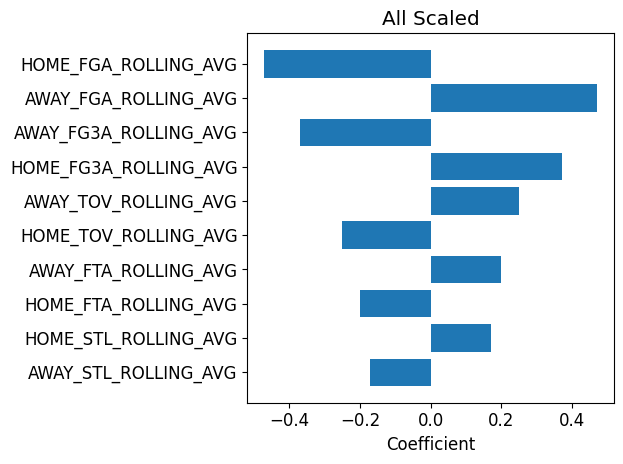

In [ ]:
# feature importance
coefs = model.coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.figure(figsize=(6.4,4.8))
plt.rcParams.update({'font.size': 12})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10), np.array(std_ftrs)[sorted_indcs[-10:]])
plt.xlabel('Coefficient')
plt.title('All Scaled')
plt.tight_layout()
#plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
plt.show()

# Other Models/Possible Improvements


---



## Possible Improvements
* Aiming for a accuracy better than 61.9%
* Going to try and see if training on the previous season is better at predicting the following season
 * Accuracy went **down** to 59.4%
* Try to see if training from beginning of Golden State Warriors dynasty to season before will increase accuracy
 * Accuracy went **down** to 58.6%


In [ ]:
# Try other models here to see if accuracy can get into the 60s
# Save the accuracies of each of the models and display in a chart
# Another option is to play with the current model or utilize hyperparameter tuning

In [ ]:
# Game_Date got turned into an object so we convert back to datetime
one_season_train_test = model_df
one_season_train_test['GAME_DATE'] = pd.to_datetime(one_season_train_test['GAME_DATE'])

In [ ]:
# 2021 season as train data
train_data = one_season_train_test.loc[(one_season_train_test['GAME_DATE'] >= season_2015_2016_start_date) & (one_season_train_test['GAME_DATE'] <= season_2022_2023_start_date)]
train_data

In [ ]:
test_data = one_season_train_test.loc[(one_season_train_test['GAME_DATE'] >= season_2022_2023_start_date) & (one_season_train_test['GAME_DATE'] <= present)]
test_data

In [ ]:
X_train = train_data.loc[:, (train_data.columns != 'OUTCOME') & (train_data.columns != 'GAME_DATE')]
y_train = train_data['OUTCOME']
X_test = test_data.loc[:, (test_data.columns != 'OUTCOME') & (test_data.columns != 'GAME_DATE')]
y_test = test_data['OUTCOME']

In [ ]:
X_train_prep = prep.fit_transform(X_train)
X_test_prep = prep.transform(X_test)

In [ ]:
model = LogisticRegression()
model.fit(X_train_prep, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test_prep)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Accuracy Score:  0.5859697386519945


## Other Models
* Try random forest ML model and see if that is able to increase the accuracy
 * Accuracy is much lower at **57.8%**


### LinearSVC
* Accuracy slightly lower at **61.3%**

In [ ]:
train_data_divider_index=int(num_rows*.80)

In [ ]:
train_data = model_df.iloc[:train_data_divider_index]
test_data = model_df.iloc[train_data_divider_index:]

In [ ]:
X_train = train_data.loc[:, (train_data.columns != 'OUTCOME') & (train_data.columns != 'GAME_DATE')]
y_train = train_data['OUTCOME']
X_test = test_data.loc[:, (test_data.columns != 'OUTCOME') & (test_data.columns != 'GAME_DATE')]
y_test = test_data['OUTCOME']

In [ ]:
X_train_prep = prep.fit_transform(X_train)
X_test_prep = prep.transform(X_test)

In [ ]:
model = svm.LinearSVC(C=1, random_state=42, max_iter=10000)
model.fit(X_train_prep, y_train)

LinearSVC(C=1, max_iter=10000, random_state=42)

In [ ]:
y_pred = model.predict(X_test_prep)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Accuracy Score:  0.6135551447935921


### Neural Network
 * Accuracy **61.7%**

In [ ]:
num_rows = model_df.shape[0]
train_data_divider_index=int(num_rows*.80)

In [ ]:
train_data = model_df.iloc[:train_data_divider_index]
test_data = model_df.iloc[train_data_divider_index:]

In [ ]:
X_train = train_data.loc[:, (train_data.columns != 'OUTCOME') & (train_data.columns != 'GAME_DATE')]
y_train = train_data['OUTCOME']
X_test = test_data.loc[:, (test_data.columns != 'OUTCOME') & (test_data.columns != 'GAME_DATE')]
y_test = test_data['OUTCOME']

In [ ]:
X_train = X_train.reset_index()
X_train = X_train.drop('index', axis=1)

In [ ]:
# convert to pytorch tensors
X_train_tensor = t.tensor(X_train.values).float()
#X_train_tensor = X_train_tensor/X_train_tensor.max(0,keepdim=True)[0]
X_test_tensor = t.tensor(X_test.values).float()
print(X_train.shape)
y_train_tensor = t.tensor(y_train.values).long()
print(y_train.shape)
y_test_tensor = t.tensor(y_test.values).long()

(32459, 36)
(32459,)


In [ ]:
# validation split
num_rows = X_test_tensor.shape[0]
val_data_divider_index=int(num_rows*.5)
X_val_tensor = X_test_tensor[:val_data_divider_index]
y_val_tensor = y_test_tensor[:val_data_divider_index]
X_test_tensor = X_test_tensor[val_data_divider_index:]
y_test_tensor = y_test_tensor[val_data_divider_index:]

In [ ]:
max_values = X_train_tensor.max(0,keepdim=True)[0]

X_train = X_train_tensor/max_values
y_train = y_train_tensor

X_val = X_val_tensor/max_values
y_val = y_val_tensor


X_test = X_test_tensor/max_values
y_test = y_test_tensor

In [ ]:
train_data = [(X_train[i,:], y_train[i]) for i in range(y_train.shape[0])] # list of tensors

test_data   = [(X_test[i, :], y_test[i]) for i in range(y_test.shape[0])] # list of tensors

val_data   = [(X_val[i, :], y_val[i]) for i in range(y_val.shape[0])] # list of tensors

In [ ]:
hyperparameters = {
    'lr':0.01,
    'hidden_layer_size_1':20,
    'hidden_layer_size_2':20,
    'batch_size':256,
    'number_of_epochs':500,
    'drop_pct':0.25
}

In [ ]:
train_loader = data_utils.DataLoader(train_data, batch_size = hyperparameters["batch_size"], shuffle=True)
test_loader = data_utils.DataLoader(test_data, batch_size = hyperparameters["batch_size"], shuffle=True)
val_loader = data_utils.DataLoader(val_data, batch_size = hyperparameters["batch_size"], shuffle=True)

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim = 36, hidden_layer_size_1=64, hidden_layer_size_2=64, drop_pct=0.1):

        super(Model, self).__init__()
        self.layer1   = nn.Linear(in_features=input_dim, out_features = hyperparameters["hidden_layer_size_1"])
        #self.batchnorm1 = nn.BatchNorm1d(hyperparameters["hidden_layer_size_1"])
        self.dropout1 = nn.Dropout(p = 0.25) # drop 30% of output nodes from the previous layer during training only
        self.layer2   = nn.Linear(in_features= hyperparameters["hidden_layer_size_1"], out_features = hyperparameters["hidden_layer_size_2"])
        #self.batchnorm2 = nn.BatchNorm1d(hyperparameters["hidden_layer_size_2"])
        self.dropout2 = nn.Dropout(p = 0.25)
        self.layer3   = nn.Linear(in_features = hyperparameters["hidden_layer_size_2"], out_features = 2)
        #self.dropout3 = nn.Dropout(p = 0.25)
        #self.layer4   = nn.Linear(in_features = 20, out_features = 2)

    def forward(self, x):
        #print(x, "THIS IS X BEFORE WE DO ANYTHING")
        x = F.leaky_relu(self.layer1(x))
        #print(x, "THIS IS X AFTER LAYER 1")
        #x = self.dropout1(x)
        x = F.leaky_relu(self.layer2(x)) # self.batchnorm2(self.layer2(x)))
        #print(x, "THIS IS X AFTER LAYER 2")
        #x = self.dropout2(x)
        x = F.leaky_relu(self.layer3(x))
        #print(x, "THIS IS X AFTER LAYER 3")
        #x = self.dropout3(x)
        #x =  F.leaky_relu(self.layer4(x)) # linear outout neurons
        #return F.sigmoid(x)
        return x


In [ ]:
def weights_init_uniform(m):
  classname = m.__class__.__name__
  # for every Linear layer in a model
  if classname.find('Linear') != -1:
      # apply a uniform distribution to the weights and a bias=0
      m.weight.data.uniform_(0.0, 1.0)
      m.bias.data.fill_(0)

In [ ]:
model     = Model(X_train.shape[1], hyperparameters['hidden_layer_size_1'], hyperparameters['hidden_layer_size_2'], hyperparameters["drop_pct"])   # X_train.shape[1]
model.apply(weights_init_uniform)
optimizer = t.optim.Adam(model.parameters(), lr=hyperparameters['lr']) #SGD = stochastic gradient descent
loss_fn   = nn.CrossEntropyLoss() # BCELoss() # loss function = CrossEntropyLoss

In [ ]:
#soft_max  = t.nn.Softmax(1)
#y_m_train = soft_max(model.forward(x_train_tensor)) # y_m normalized with softmax
#y_m_train = t.argmax(y_m_train,dim = 1)

def accuracy(data_loader):
  correct_pred = 0
  total_inputs  = 0
  model.eval()
  for x,y_target in data_loader:
    #y_m   = soft_max(model.forward(x))
    y_m = model.forward(x) # 2 outputs
    y_b = t.argmax(y_m, dim=1)
    #y_m   = t.round(y_m)
    correct_pred += t.sum(y_b == y_target) # /yv.shape[0]
    total_inputs += y_target.shape[0]

  acc = 100* correct_pred/total_inputs
  #print("Validation accuracy = ", correct_pred/total_inputs)
  return acc

#correct_pred_train = t.sum(y_m_train == y_t_train)/y_m_train.shape[0]
#print("Training accuracy = ", correct_pred_train)

In [ ]:
def train_model(n_epochs, model, train_loader, optimizer, loss_fn, val_loader, test_loader):
    experiment = Experiment(
      api_key = "2KZ3aDwn9eTzfuaF2r7gJ0Uhh",
      project_name = "capstone-project",
      workspace="ndimitrakas"
    )
    experiment.log_parameters(hyperparameters)
    best_val_acc = 0
    with experiment.train():
        for epoch in tqdm(range(n_epochs+1), desc="epoch loop", position=0):
            model.train()   # set model in training mode = with dropout
            total_train_loss = 0
            for xb,yb in tqdm(train_loader, desc="train loader loop", position=1, leave=False): # for each batch
                ym = model.forward(xb)
                #print(ym.shape, xb.shape, yb.shape)
                loss = loss_fn(ym,yb) #.float()) # compute the loss between ym = output of the model and yb = correct output
                total_train_loss += loss
                optimizer.zero_grad() # set gradients to 0
                loss.backward()       # compute the gradients
                optimizer.step()      # adjust the weights according to the gradients and the learning rate

            #with experiment.test(): #if epoch == 1 or epoch % 20 == 0:
            model.eval() # set model in evaluation mode = no dropout
            train_acc = accuracy(train_loader)
            val_acc = accuracy(val_loader)
            experiment.log_metric("Validation Accuracy", val_acc, step=epoch)
            experiment.log_metric("Train Accuracy", train_acc, step=epoch)
            #if last_val_loss < loss_val:
            #    print("Early stopping at epoch", epoch)

            if val_acc > best_val_acc: # save the model
              best_val_acc = val_acc
              #print("Saved best model", min_val_loss, val_acc)
              t.save(model.state_dict(), "best_model")

    experiment.end()

In [ ]:
train_model(n_epochs = hyperparameters['number_of_epochs'], model = model,
            train_loader = train_loader, optimizer = optimizer,
            loss_fn = loss_fn, val_loader = val_loader, test_loader = test_loader)

In [ ]:
# compute accuracy of the best model
model.load_state_dict(t.load("best_model"))
model.eval()

Model(
  (layer1): Linear(in_features=36, out_features=20, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (layer3): Linear(in_features=20, out_features=2, bias=True)
)

In [ ]:
print(accuracy(val_loader), accuracy(train_loader), accuracy(test_loader))

tensor(62.8050) tensor(62.7130) tensor(60.0789)


# Test Model with an Upcoming Game **(DEMO)**


---



In [ ]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
# in order to test out an upcoming game (NY vs MIA Game 1)
# need to calc their 10 game rolling avg coming into the game and give it to the model
# 1 row of knicks data first as home data and heat data as away

mianyk_df = pd.DataFrame()

# Close Out Games Round 1
lakers_griz_6_data = [42.6, 91.9, .463, 12, 34.1, .348, 17.1, 21.6, .789, 11.2, 37.3, 48.5, 24.9, 6.4, 7, 13.7, 16.3, 115.8, 42.1, 93.6, .45, 13.4, 39.9, .332, 15.2, 19.2, .793, 12.3, 35.8, 48.1, 27.7, 6.1, 4.7, 12.8, 20, 112.8]
kings_warriors_6_data = [45.3, 93.3, .488, 15.9, 41.7, .379, 18.2, 22.4, .818, 13.7, 36.1, 49.8, 30.2, 8.6, 5, 15, 21.3, 124.7, 42.7, 95.7, .446, 11.8, 39.1, .306, 17.2, 22.7, .751, 14, 30.9, 44.9, 24.6, 8.2, 3.6, 13.3, 20.7, 114.4]
kings_warriors_7_data = [41.8, 95.3, .439, 12.4, 39.2, .319, 16.8, 22, .756, 14.5, 31.4, 45.9, 24.7, 8.3, 3.9, 13.7, 21, 112.8, 43.8, 92.6, .474, 14.8, 40, .367, 19.2, 23.8, .818, 13.4, 36.1, 49.5, 28.5, 9.5, 5.2, 15.4, 21.8, 121.6]
suns_clip_5_data = [42.4, 87.9, .486, 10.8, 29.5, .367, 20.1, 25.6, .795, 10.7, 33.7, 44.4, 26.4, 7, 6.6, 11.5, 18.6, 115.7, 42.6, 87.6, .488, 12.5, 32.8, .374, 20, 24.8, .804, 10, 31.5, 41.5, 23.9, 6.6, 5, 13.8, 21.1, 117.7]
knicks_cavs_5_data = [39.9, 84.7, .471, 11.5, 31.2, .364, 14.2, 18.4, .785, 9.3, 29.5, 38.8, 24.3, 6.8, 5.9, 13.1, 20.8, 105.5, 41.8, 88.7, .469, 12.3, 34.8, .349, 16.1, 23, .698, 13.6, 31.9, 45.5, 22.9, 9.6, 4.8, 12.5, 17.5, 112]
bucks_heat_5_data = [43.1, 91.1, .475, 16.2, 41.5, .387, 12.4, 16.8, .756, 10.6, 33.2, 43.8, 28.1, 6.4, 3.8, 13.9, 16.6, 114.8, 43.2, 85.7, .505, 14.5, 35.6, .414, 16.8, 21.1, .785, 8, 34.4, 42.4, 26.5, 8.4, 2.7, 13.2, 19, 117.7]
hawks_celts_6_data = [45.1,	93.9,	0.483,	12.3,	36,	0.341,	16.8,	21.3,	0.784,	12.2,	34.3,	46.5,	26,	8.3, 5.4,	13.7,	17.6,	119.3, 43.5,	89.3,	0.489,	16,	42.4,	0.376,	13,	17.3,	0.738,	10,	35.6,	45.6,	28.5,	5.8,	5.8,	13.5,	15.5,	116]
nets_76ers_4_data = [37.7,	83.1,	0.455,	12,	35.5,	0.343,	16.2,	21,	0.766,	7.7,	30.9,	38.6,	25.3,	6.8,	4.4,	11.3,	16.9,	103.6, 41.8,	84.8,	0.493,	13.2,	33.1,	0.401,	16.2,	19.2,	0.845,	10.4,	32.3,	42.7,	24.9,	7.6,	4.3,	13.6,	19.6,	113]
nugg_timbs_5_data = [42.7,	89.3,	0.481,	10.7,	32,	0.335, 14.4, 20.1,	0.715,	10.9,	34.3,	45.2,	25.3,	8.2,	5.2,	12.9,	19.9,	110.5, 40.1,	84.5,	2.03,	15.8,	33.5,	0.448,	18.1,	23.4,	0.771,	8,	33.8,	41.8,	26.5,	7.3,	6.6,	13.4,	19.2, 111.6]

In [ ]:
# Celtics vs 76ers Games
celtics_76ers_1_data = [44,	89.1,	0.4947,	16.1, 41.5,	0.3858,	12.5,	16.8,	0.737,	10.1,	36,	46.1,	28.2,	5.7,	6.4, 13.1,	15.7,	116.6,  41.7,	85.9, 0.487,	12.4, 31.9,	0.391,	15.2,	17.8,	0.856,	10.8,	33, 43.8,	24.2,	7.4,	4.2,	13.4,	19.6,	111]
celtics_76ers_2_data = [44.6,	87.5,	0.512,	15.6,	39.6,	0.391,	13.2,	17,	0.769,	9.6,	36,	45.6,	28,	5.6,	6.4,	13.9,	15,	118, 42.1,	87.5,	0.481,	12.9,	32.6,	0.397,	14.1,	16.5,	0.864,	10.7,	32.2,	42.9,	23.1,	7.7,	4,	12.4,	19.6,	111.2]
celtics_76ers_3_data = [41.2,	86.7,	0.474,	12.3,	32,	0.384,	14.8,	17.5,	0.854,	10.2,	33.2,	43.4,	22.5,	7.6,	4.6,	12.4,	19.6,	109.5, 45.1,	87.8,	0.516,	16.5,	40.9,	0.401,	13.7,	16.8,	0.807,	9.3,	36.1,	45.4,	28.6,	5.7,	6.5, 13,	15.3,	120.4]
celtics_76ers_4_data = [40.4,	86.7,	0.464,	12.8,	32.8,	0.389,	15.8,	18.6,	0.856,	10.5,	33.4,	43.9,	22.5,	8,	4.7,	12.7,	19.5,	109.4, 44.4,	88.3,	0.504,	16.6,	41,	0.403,	14.3,	17,	0.827,	8.9,	35.7,	44.6,	27.4,	6.2,	6.5,	12.3,	16.2,	119.7]
celtics_76ers_5_data = [44.3,	88.1,	0.504,	15.5,	40,	0.388,	14.8,	17.8,	0.821,	9,	35.3,	44.3,	26.6,	6,	7.4,	11.8,	17,	119.2, 40.4,	86.7,	0.464,	12.8,	32.8,	0.389,	15.8,	18.6,	0.856,	10.5,	33.4,	43.9,	22.5,	8,	4.7,	12.7,	19.5,	109.4]
celtics_76ers_6_data = [40.7,	88.2,	0.459,	13.1,	32.6,	0.4,	16.4,	19.3,	0.855,	11.4,	33.7,	45.1,	22.1,	8.2,	4.6,	11.9,	20,	110.9, 43.4,	87.6,	0.496,	15.4,	40.5,	0.381,	15.8,	19.4,	0.811,	8.7,	33.4,	42.1,	26.2,	5.8,	6.8,	11,	17.1,	118.3]

In [ ]:
# Knicks vs Heat Games
knicks_heat_1_data = [41.7, 89.6, .463, 11.9, 34.6, .338, 17.2, 23.6, .725, 14.4, 31.2, 45.6, 22.8, 9.4, 5, 12, 17.8, 112.5, 44.1, 88.7, .499, 14.9, 36.5, .416, 15.6, 20.2, .761, 8.4, 35.2, 43.6, 26.4, 7.8, 3, 13.6, 20.3, 118.7]
knicks_heat_2_data = [40.9,	88.9,	0.458,	10.9,	34.4,	0.311,	16.9,	23.2,	0.723,	14, 31.6,	45.6,	22.4,	9.4,	4.9,	12.6,	18.7,	109.6, 42.8,	88.4,	0.486,	14.4,	36.5,	0.403,	16.6,	21.6,	0.754, 8.3,	34.9,	43.2,	25.1,	8.3,	3.5,	13.4,	20.4, 116.6]
knicks_heat_3_data = [42.3,	87.1,	0.487,	14.6,	36.7,	0.406,	17.1,	22.1,	0.766,	7.7,	34.2,	41.9,	24.9,	7.7,	3.3,	12.4,	19.9,	116.3, 40,	88.3,	0.451,	11.2,	35.2,	0.310,	17.7,	24.4,	0.721,	14.4,	32.3,	46.7,	21.6,	8.6,	4.7,	12.5,	19,	108.9]
knicks_heat_4_data = [41.3,	87.8,	0.472,	13.5,	35.5,	0.387,	18.4,	23.2,	0.782,	8.3,	34.2,	42.5,	23.6,	7,	3.5,	11.9,	20.4,	114.5, 37.9,	87.4,	0.433,	10.2,	34.6,	0.291,	17.7,	24.1,	0.729,	13.8,	32.5,	46.3,	19.7,	7.7,	4.2,	12.4,	19.1,	103.7]
knicks_heat_5_data = [37.8,	86.2,	0.438,	9.7,	33.1,	0.291,	18,	24.5,	0.729,	13.9,	32.2,	46.1,	19.9,	7.7,	4.4,	13.1,	19.7,	103.3, 41.4,	87.2,	0.476,	13.7,	36,	0.388,	18.4,	23.4,	0.7743,	9,	34,	43,	24,	7,	3.5,	12.3,	20.6,	114.9]

In [ ]:
# Nuggets vs Suns Games
nugg_suns_1_data = [42.3, 88.3, .481, 11.3, 32.8, .347, 16.5, 21.7, .749, 11, 33.8, 44.8, 25.6, 8.1, 5, 13, 20.4, 112.4, 43.8, 88.5, .498, 11.1, 29.4, .38, 20.6, 25.9, .807, 10.5, 33.1, 43.6, 26.7, 6.9, 6.3, 10.6, 19.7, 119.3]
nugg_suns_2_data = [42.7,	88.4,	0.484,	12,	33.2,	0.363,	16.3,	21.4,	0.753,	10.9,	34.1,	45,	25.4,	8.4,	4.4,	12.8,	20.6,	113.7, 43.5,	88.8,	0.492,	10.5,	28.3,	0.372,	19.7,	24.8,	0.807,	10.8,	32.8,	43.6,	25.6,	6.9,	6.2,	10.9,	18.6,	117.2]
nugg_suns_3_data = [43,	89.4,	0.484,	10.1,	28.1,	0.361,	18.3,	22.7,	0.834,	10.4,	31.4,	41.8,	25.4,	6.4,	5.9,	10.5,	19.9,	114.4, 42.2,	87.3,	0.4845,	11.6,	32.3,	0.358,	17.1,	21.7,	0.783,	10.1,	34.3,	44.4,	24.7,	8,	3.7,	11.8,	20.4,	113.1]
nugg_suns_4_data = [43.7,	91,	0.483,	9.3,	27.3,	0.346,	17.9,	22,	0.843,	10.4,	32.2,	42.6,	25.2,	6.5,	5.9,	10.4,	20.7,	114.6, 42.1,	88.7,	0.476,	11.8,	33,	0.357,	17,	21.5,	0.786,	10.8,	34.9,	45.7,	25,	7.9,	4,	11.8,	20.6,	113]
nugg_suns_5_data = [43,	88.6,	0.486,	11,	30.6,	0.356,	17,	21.4,	0.789,	11.3,	33.5,	44.8,	24.6,	7.8,	3.3,	11.2,	20.5,	114, 44,	88.7,	0.498,	9.7,	26.6,	0.366,	19.1,	23.5,	0.84,	10.3,	31.3,	41.6,	25.7,	6.4,	5.3,	10.8,	21.9,	116.8]
nugg_suns_6_data = [43.6,	87.6,	0.499,	9.2,	25.6,	0.361,	19.2,	23.7,	0.838,	9.9,	31.2,	41.1,	25,	6.6,	5.7,	11.1,	22,	115.6, 43,	88.7,	0.486,	11.6,	30.5,	0.379,	17.3,	21.7,	0.792,	10.8,	33.9,	44.7,	25.3,	7.3,	3.7,	10.6,	20.7,	114.9]

In [ ]:
# Lakers vs Warriors Games
lakers_warriors_1_data = [43.9,	92.1,	0.477,	15.4,	40.4,	0.378,	19.4,	25.1,	0.781,	13,	36.3,	49.3,	28.4,	9,	5.4,	14.6,	21.9,	122.6, 42.7,	91.4,	0.467,	12.3, 35.1,	0.346,	17.1,	21.6,	0.792,	11,	38.3,	49.3,	25.5,	6.4,	7.8,	13.9,	15.8,	114.8]
lakers_warriors_2_data = [43.5,	93.2,	0.468,	15.5,	41,	0.375,	17.7,	22.7,	0.791,	12.5,	36.3,	48.8,	28.9,	8.9,	5.1,	14.1,	22.1,	120.2, 42.5,	91.7,	0.463,	11.7,	34.7,	0.329,	18,	22.1,	0.811,	11.3,	38.9,	50.2,	25.3,	6.4,	8.5,	13.3,	15.3,	114.7]
lakers_warriors_3_data = [42,	91.9,	0.4568,	10.9,	34.5,	0.308,	17.7,	22.1,	0.794,	11.2,	37.6,	48.8,	25.5,	6.7,	8.2,	12.7,	15.6,	112.6, 44.2,	94.9,	0.466,	16,	41.6,	0.381,	16.6,	21.9,	0.766,	12.8,	36.8,	49.6,	29.1,	8.5,	4.7,	13.2,	22.2,	121]
lakers_warriors_4_data = [41.5,	90.2,	0.461,	10.6,	33.1,	0.317,	43.9,	23.7,	1.469,	10.8,	37.5,	48.3,	25.4,	7.3,	8.1,	12.9,	16.8,	112.5, 42,	94.4,	0.446,	14.6,	41.1,	0.3551,	16.4,	22,	0.749,	13.3,	34.7,	48,	27,	7.7,	4.7,	13.6,	22.6,	115]
lakers_warriors_5_data = [42,	94.4,	0.446,	14.6,	41.1,	0.355,	16.4,	22,	0.749,	13.3,	34.7,	48,	27,	7.7,	4.7,	13.6,	22.6,	115, 41.5,	90.2,	0.461,	10.6,	33.1,	0.317,	43.9,	23.7,	1.469,	10.8,	37.5,	48.3,	25.4,	7.3,	8.1,	12.9,	16.8,	112.5]

In [ ]:
mianyk_df[home_columns] = ''
mianyk_df[away_columns] = ''

#mianyk_df.loc[len(mianyk_df)] = knicks_heat_1_data
#mianyk_df.loc[len(mianyk_df)] = lakers_griz_6_data
#mianyk_df.loc[len(mianyk_df)] = kings_warriors_7_data
#mianyk_df.loc[len(mianyk_df)] = kings_warriors_6_data
#mianyk_df.loc[len(mianyk_df)] = nugg_suns_1_data
#mianyk_df.loc[len(mianyk_df)] = suns_clip_5_data
#mianyk_df.loc[len(mianyk_df)] = knicks_cavs_5_data
#mianyk_df.loc[len(mianyk_df)] = bucks_heat_5_data
#mianyk_df.loc[len(mianyk_df)] = hawks_celts_6_data
#mianyk_df.loc[len(mianyk_df)] = nets_76ers_4_data
#mianyk_df.loc[len(mianyk_df)] = celtics_76ers_1_data
#mianyk_df.loc[len(mianyk_df)] = nugg_timbs_5_data
#mianyk_df.loc[len(mianyk_df)] = nugg_suns_2_data
#mianyk_df.loc[len(mianyk_df)] = knicks_heat_2_data
#mianyk_df.loc[len(mianyk_df)] = lakers_warriors_1_data
#mianyk_df.loc[len(mianyk_df)] = celtics_76ers_2_data
#mianyk_df.loc[len(mianyk_df)] = lakers_warriors_2_data
#mianyk_df.loc[len(mianyk_df)] = nugg_suns_3_data
#mianyk_df.loc[len(mianyk_df)] = celtics_76ers_3_data
#mianyk_df.loc[len(mianyk_df)] = knicks_heat_3_data
#mianyk_df.loc[len(mianyk_df)] = lakers_warriors_3_data
#mianyk_df.loc[len(mianyk_df)] = celtics_76ers_4_data
#mianyk_df.loc[len(mianyk_df)] = nugg_suns_4_data
#mianyk_df.loc[len(mianyk_df)] = knicks_heat_4_data
#mianyk_df.loc[len(mianyk_df)] = lakers_warriors_4_data
#mianyk_df.loc[len(mianyk_df)] = celtics_76ers_5_data
#mianyk_df.loc[len(mianyk_df)] = nugg_suns_5_data
mianyk_df.loc[len(mianyk_df)] = knicks_heat_5_data
mianyk_df.loc[len(mianyk_df)] = lakers_warriors_5_data
mianyk_df.loc[len(mianyk_df)] = celtics_76ers_6_data
mianyk_df.loc[len(mianyk_df)] = nugg_suns_6_data
mianyk_df

,HOME_FGM_ROLLING_AVG,HOME_FGA_ROLLING_AVG,HOME_FG_PCT_ROLLING_AVG,HOME_FG3M_ROLLING_AVG,HOME_FG3A_ROLLING_AVG,HOME_FG3_PCT_ROLLING_AVG,HOME_FTM_ROLLING_AVG,HOME_FTA_ROLLING_AVG,HOME_FT_PCT_ROLLING_AVG,HOME_OREB_ROLLING_AVG,...,AWAY_FT_PCT_ROLLING_AVG,AWAY_OREB_ROLLING_AVG,AWAY_DREB_ROLLING_AVG,AWAY_REB_ROLLING_AVG,AWAY_AST_ROLLING_AVG,AWAY_STL_ROLLING_AVG,AWAY_BLK_ROLLING_AVG,AWAY_TOV_ROLLING_AVG,AWAY_PF_ROLLING_AVG,AWAY_PTS_ROLLING_AVG
0,37.8,86.2,0.438,9.7,33.1,0.291,18.0,24.5,0.729,13.9,...,0.7743,9.0,34.0,43.0,24.0,7.0,3.5,12.3,20.6,114.9
1,42.0,94.4,0.446,14.6,41.1,0.355,16.4,22.0,0.749,13.3,...,1.4690,10.8,37.5,48.3,25.4,7.3,8.1,12.9,16.8,112.5
2,40.7,88.2,0.459,13.1,32.6,0.400,16.4,19.3,0.855,11.4,...,0.8110,8.7,33.4,42.1,26.2,5.8,6.8,11.0,17.1,118.3
3,43.6,87.6,0.499,9.2,25.6,0.361,19.2,23.7,0.838,9.9,...,0.7920,10.8,33.9,44.7,25.3,7.3,3.7,10.6,20.7,114.9


In [ ]:
X_test = mianyk_df
X_test

,HOME_FGM_ROLLING_AVG,HOME_FGA_ROLLING_AVG,HOME_FG_PCT_ROLLING_AVG,HOME_FG3M_ROLLING_AVG,HOME_FG3A_ROLLING_AVG,HOME_FG3_PCT_ROLLING_AVG,HOME_FTM_ROLLING_AVG,HOME_FTA_ROLLING_AVG,HOME_FT_PCT_ROLLING_AVG,HOME_OREB_ROLLING_AVG,...,AWAY_FT_PCT_ROLLING_AVG,AWAY_OREB_ROLLING_AVG,AWAY_DREB_ROLLING_AVG,AWAY_REB_ROLLING_AVG,AWAY_AST_ROLLING_AVG,AWAY_STL_ROLLING_AVG,AWAY_BLK_ROLLING_AVG,AWAY_TOV_ROLLING_AVG,AWAY_PF_ROLLING_AVG,AWAY_PTS_ROLLING_AVG
0,37.8,86.2,0.438,9.7,33.1,0.291,18.0,24.5,0.729,13.9,...,0.7743,9.0,34.0,43.0,24.0,7.0,3.5,12.3,20.6,114.9
1,42.0,94.4,0.446,14.6,41.1,0.355,16.4,22.0,0.749,13.3,...,1.4690,10.8,37.5,48.3,25.4,7.3,8.1,12.9,16.8,112.5
2,40.7,88.2,0.459,13.1,32.6,0.400,16.4,19.3,0.855,11.4,...,0.8110,8.7,33.4,42.1,26.2,5.8,6.8,11.0,17.1,118.3
3,43.6,87.6,0.499,9.2,25.6,0.361,19.2,23.7,0.838,9.9,...,0.7920,10.8,33.9,44.7,25.3,7.3,3.7,10.6,20.7,114.9


In [ ]:
X_test_prep = prep.transform(X_test)

In [ ]:
model = LogisticRegression(random_state=42)
model.fit(X_train_prep, y_train)

LogisticRegression(random_state=42)

In [ ]:
y_pred = model.predict(X_test_prep)
print(y_pred)

[0 0 0 0]


# **LIVE:** Model Prediction Log
* Lets see how the model does predicting some playoff games
* Produce a confusion matrix

In [ ]:
live_prediction_log_df = pd.DataFrame()
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/22/23', 'PHI @ BKN', 0, 0] # prediction PHI win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/25/23', 'MIN @ DEN', 0, 1] # prediction MIN win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/25/23', 'LAC @ PHX', 1, 1] # prediction PHX win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/26/23', 'NYK @ CLE', 0, 0] # prediction NYK win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/26/23', 'MIA @ MIL', 0, 0] # prediction MIA win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/26/23', 'BOS @ ATL', 0, 0] # prediction BOS win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/28/23', 'SAC @ GSW', 1, 0] # prediction GSW win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/28/23', 'MEM @ LAL', 0, 1] # prediction MEM win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/29/23', 'PHX @ DEN', 0, 1] # prediction PHX win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/30/23', 'MIA @ NYK', 1, 0] # prediction NYK win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['4/30/23', 'GSW @ SAC', 0, 0] # prediction GSW win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/1/23', 'PHI @ BOS', 1, 0] # prediction BOS win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/1/23', 'PHX @ DEN', 1, 1] # prediction DEN win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/2/23', 'MIA @ NYK', 1, 1] # prediction NYK win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/2/23', 'LAL @ GSW', 1, 0] # prediction GSW win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/3/23', 'PHI @ BOS', 1, 1] # prediction BOS win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/4/23', 'LAL @ GSW', 1, 1] # prediction GSW win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/3/23', 'DEN @ PHX', 0, 1] # prediction DEN win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/6/23', 'NYK @ MIA', 0, 1] # prediction NYK win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/6/23', 'GSW @ LAL', 0, 1] # prediction GSW win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/7/23', 'BOS @ PHI', 0, 1] # prediction BOS win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/7/23', 'DEN @ PHX', 0, 1] # prediction DEN win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/8/23', 'NYK @ MIA', 0, 1] # prediction NYK win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/8/23', 'GSW @ LAL', 1, 1] # prediction LAL win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/9/23', 'PHI @ BOS', 1, 0] # prediction BOS win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/9/23', 'PHX @ DEN', 1, 1] # prediction DEN win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/10/23', 'MIA @ NYK', 0, 1] # prediction MIA win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/10/23', 'LAL @ GSW', 0, 1] # prediction LAL win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/11/23', 'BOS @ PHI', 0, 0] # prediction BOS win
live_prediction_log_df.loc[len(live_prediction_log_df), ['Game_Date', 'Matchup', 'model_Prediction', 'actual_outcome']]=['5/11/23', 'DEN @ PHX', 0, 0] # prediction DEN win

live_prediction_log_df

,Game_Date,Matchup,model_Prediction,actual_outcome
0,4/22/23,PHI @ BKN,0.0,0.0
1,4/25/23,MIN @ DEN,0.0,1.0
2,4/25/23,LAC @ PHX,1.0,1.0
3,4/26/23,NYK @ CLE,0.0,0.0
4,4/26/23,MIA @ MIL,0.0,0.0
5,4/26/23,BOS @ ATL,0.0,0.0
6,4/28/23,SAC @ GSW,1.0,0.0
7,4/28/23,MEM @ LAL,0.0,1.0
8,4/29/23,PHX @ DEN,0.0,1.0
9,4/30/23,MIA @ NYK,1.0,0.0


In [ ]:
actual = live_prediction_log_df['actual_outcome'].values.tolist()
predicted = live_prediction_log_df['model_Prediction'].values.tolist()

In [ ]:
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
print("Accuracy:", accuracy)
print("Precision:", precision)

Accuracy: 0.42857142857142855
Precision: 0.5833333333333334


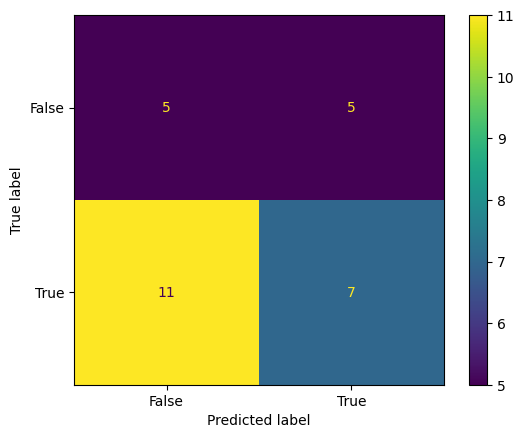

In [ ]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()